In [23]:
import os
import numpy as np
from skimage.io import imread, imread_collection
from skimage.transform import resize
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers, Sequential
import matplotlib.pyplot as plt
from sklearn.utils import compute_class_weight

SEED = 67
IMG_SIZE = (256, 256)
BATCH_SIZE = 32
DATA_PATH = "../data"
TEST_PERCENT = .7
VAL_PERCENT = .15

np.random.seed(SEED)
tf.random.set_seed(SEED)

<h1>Arrange Data</h1>

In [24]:

dataset = tf.keras.utils.image_dataset_from_directory(
    DATA_PATH,
    image_size=IMG_SIZE,
    seed=SEED,
    batch_size=BATCH_SIZE,
    shuffle=True
)

#Normalize the pixels
#dataset = dataset.map(lambda x, y: (tf.cast(x, tf.float32) / 255.0, y))

#Split the datasets after loading in a shuffled version
total_batches = tf.data.experimental.cardinality(dataset).numpy()

train_size = int(TEST_PERCENT * total_batches)
val_size   = int(VAL_PERCENT * total_batches)
test_size  = total_batches - train_size - val_size

train_ds = dataset.take(train_size)
val_ds   = dataset.skip(train_size).take(val_size)
test_ds  = dataset.skip(train_size + val_size)


Found 5856 files belonging to 3 classes.


<h1>Visualize model training</h1>

In [28]:
#Ignore first value because it starts off really really bad
def plot_training_curves(history, title_prefix="Model"):
    """Plot training & validation accuracy and loss (separate charts)."""
    # Accuracy plot
    plt.figure()
    plt.plot(history.history.get("accuracy", []), label="train_acc")
    if "val_accuracy" in history.history:
        plt.plot(history.history["val_accuracy"][1:], label="val_acc")
    plt.title(f"{title_prefix} — Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

    # Loss plot
    plt.figure()
    plt.plot(history.history.get("loss", []), label="train_loss")
    if "val_loss" in history.history:
        plt.plot(history.history["val_loss"][1:], label="val_loss")
    plt.title(f"{title_prefix} — Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

<h1>Extract class weights to make it a little more balanced</h1>

In [26]:

y_train = np.concatenate([y.numpy() for _, y in train_ds], axis=0)

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weight_dict = dict(enumerate(class_weights))


<h1>Complex CNN</h1>

Epoch 1/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 43s 326ms/step - accuracy: 0.4314 - loss: 3.8546 - val_accuracy: 0.5590 - val_loss: 1.1068
Epoch 2/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 46s 351ms/step - accuracy: 0.6367 - loss: 0.8718 - val_accuracy: 0.6667 - val_loss: 0.8829
Epoch 3/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 29s 224ms/step - accuracy: 0.6897 - loss: 0.7649 - val_accuracy: 0.6771 - val_loss: 0.8165
Epoch 4/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 30s 231ms/step - accuracy: 0.7019 - loss: 0.7359 - val_accuracy: 0.7234 - val_loss: 0.8281
Epoch 5/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 30s 230ms/step - accuracy: 0.7144 - loss: 0.6997 - val_accuracy: 0.7130 - val_loss: 0.7817
Epoch 6/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 30s 236ms/step - accuracy: 0.7373 - loss: 0.6770 - val_accuracy: 0.6991 - val_loss: 0.7499
Epoch 7/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 31s 236ms/step - accuracy: 0.7339 - loss: 0.6747 - val_accuracy: 0.7396 - val_loss: 0.7471
Epoch 8/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 32s 247ms/step - accuracy: 0.7446 - loss: 0

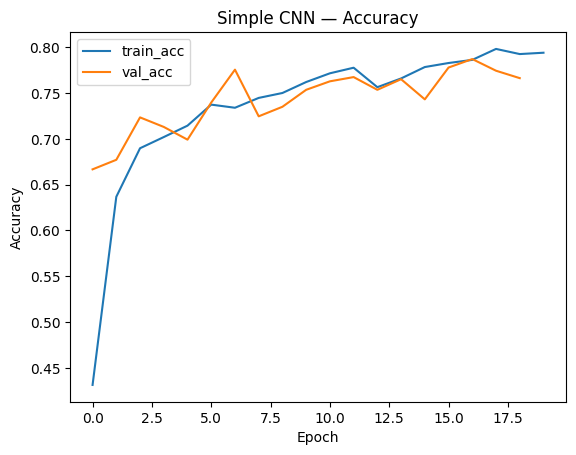

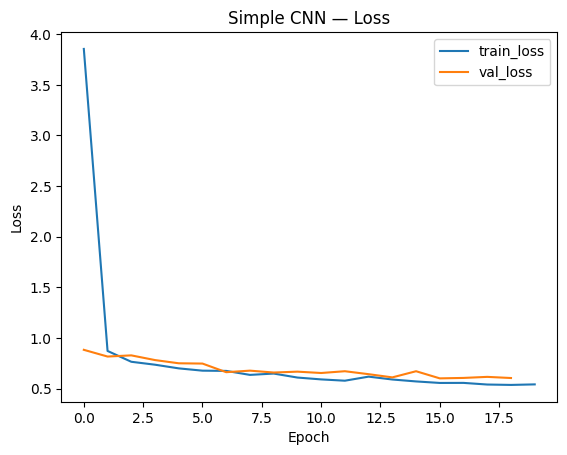

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 256, 256, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 85, 85, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 85, 85, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 85, 85, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 28, 28, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 9, 9, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 9, 9, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 9, 9, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 4, 4, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 2, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 2, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 128)            │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,673,504 (6.38 MB)

 Trainable params: 557,834 (2.13 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,115,670 (4.26 MB)

In [27]:
cnn_simple = Sequential([
    layers.Input(shape=(IMG_SIZE + (3,))),

    #Layer 1
    layers.Conv2D(32, (3,3), activation="relu", padding="same", kernel_regularizer=regularizers.l2(1e-4)),
    layers.MaxPooling2D((3,3)),
    layers.Dropout(0.3),

    #Layer 2
    layers.Conv2D(64, (3,3), activation="relu", padding="same", kernel_regularizer=regularizers.l2(1e-4)),
    layers.MaxPooling2D((3,3)),
    layers.Dropout(0.2),

    #Layer 3
    layers.Conv2D(64, (3,3), activation="relu", padding="same", kernel_regularizer=regularizers.l2(1e-4)),
    layers.MaxPooling2D((3,3)),
    layers.Dropout(0.2),

    #Layer 4
    layers.Conv2D(128, (3,3), activation="relu", padding="same", kernel_regularizer=regularizers.l2(1e-4)),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.1),

    #Layer 5
    layers.Conv2D(256, (3,3), activation="relu", padding="same", kernel_regularizer=regularizers.l2(1e-4)),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.1),


    #Output layer
    layers.Flatten(),
    layers.Dense(128, activation="relu", kernel_regularizer=regularizers.l2(1e-4)),
    layers.Dropout(0.2),
    layers.Dense(10, activation="softmax"),
])

cnn_simple.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True,
)


history_cnn_simple = cnn_simple.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    batch_size=128,
    verbose=1,
    callbacks=[early_stop],
    class_weight=class_weight_dict
)

plot_training_curves(history_cnn_simple, title_prefix="Simple CNN")
cnn_simple.summary()